In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

In [3]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 7

In [4]:
systems_df = pd.read_csv('../data3/raw/Novel Refseq1k domains - hit_proteins.csv')
domains_df = pd.read_csv('../data3/raw/Novel Refseq1k domains - hhpred_domains.csv')
tm_df = pd.read_csv('../data3/raw/Novel Refseq1k domains - tm.csv')
tm_df['Domain Name'] = 'TM'

In [5]:
predictions = pd.read_parquet('../data3/processed/refseq_1k_predictions.pq')


In [6]:
merged_systems_df = (systems_df.merge(predictions[['genomic_accession', 'start', 'product_accession',
                                                   'mean_log_odds']], 
                                      how='inner', 
                                      on=['genomic_accession', 'start', 'product_accession']))

In [7]:
(merged_systems_df.groupby('working_id')
 .agg({'mean_log_odds': 'max'}))

,mean_log_odds
working_id,
AGPT,6.826537
DUTP,7.006573
GLYO,5.513262
HARP,7.743716
M15P,7.760609
MZG1,8.034708
NMAD,9.029726
PUP2,6.422058


In [8]:
cat_domains = pd.concat([domains_df, 
                         tm_df])

## Plot systems

In [9]:
sys_height = 0.25

In [10]:
def plot_system(system_df, cat_domains, show_scale=True, show_prob_cmap=False, 
                hhpred_cmap=None, sys_height=sys_height, clip_on=False):
    sys_height += -0.05
    if hhpred_cmap is None:
        hhpred_cmap = sns.color_palette("light:#E8020B", as_cmap=True)
    total_length = system_df['product_length'].sum() + 3*len(system_df)
    fig, ax = plt.subplots(figsize=(3.9, sys_height))
    ax.set_clip_on(clip_on)
    x_offset = 0
    if system_df['strand'].to_list()[0] == '-':
        system_df = system_df.sort_values('start', ascending=False).reset_index(drop=True)
    else:
        system_df = system_df.sort_values('start', ascending=True).reset_index(drop=True)
    for _, protein_series in system_df.iterrows():
        product_accession = protein_series['product_accession']
        protein_length = protein_series['product_length']
        protein_edgecolor = 'black'
        # plot individual domains
        domain_df = cat_domains[cat_domains['product_accession'] == product_accession]
        for _, domain_series in domain_df.iterrows():
            textcolor='black'
            start = domain_series['start']
            end = domain_series['end']
            label = domain_series['Domain Name']
            probability = domain_series['Domain Prob']
            if not pd.isnull(probability):
                color = hhpred_cmap(probability)                   
            else:
                color = 'darkgrey'
            domain_rect = patches.Rectangle((x_offset + start, -3), end - start, 6, facecolor=color, linewidth=0, clip_on=clip_on)
            ax.add_patch(domain_rect)
            ax.text(x_offset + ((start + end) / 2), -0.3, label, ha='center', va='center', fontdict={'color': textcolor})
        arrow_width = 6
        protein_arrow = patches.FancyArrow(x_offset, 0, protein_length, 0, 
                                           width=arrow_width, facecolor='none', edgecolor=protein_edgecolor, linewidth=1, 
                                           length_includes_head=True, head_width=arrow_width, head_length=0.05*total_length, 
                                           clip_on=clip_on)
        ax.add_patch(protein_arrow)
        x_offset += protein_length + 3
    ax.axis('off')
    if show_scale: 
        ax.hlines(-4, 0, 100, linewidth=1, color='black', zorder=0, clip_on=clip_on)
    if show_prob_cmap:
        # Add a colorbar legend
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("bottom", size="150%", )
        norm = plt.Normalize(0, 1)
        cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=hhpred_cmap), cax=cax, orientation='horizontal', 
                          fraction=0.046, pad=0.04)
        cb.set_label("HHPred Probability")

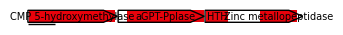

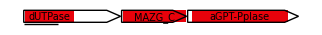

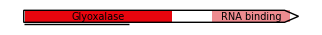

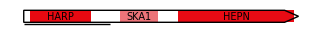

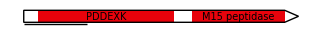

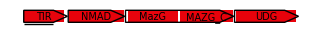

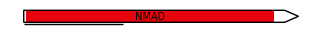

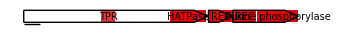

In [11]:
domain_figure_dir = '../figures/'
for system, system_df in (systems_df
                          .sort_values(['working_id', 
                                        'protein_num'])
                          .groupby('working_id')):
    plot_system(system_df, domains_df)
    plt.savefig(domain_figure_dir + 'hit_system_' + system + '.svg', dpi=300, bbox_inches='tight')

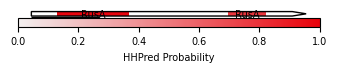

In [9]:
plot_system(system_df, domains_df, show_prob_cmap=True)
plt.savefig(domain_figure_dir + 'hit_system_cmap' + '.svg', dpi=300, bbox_inches='tight')